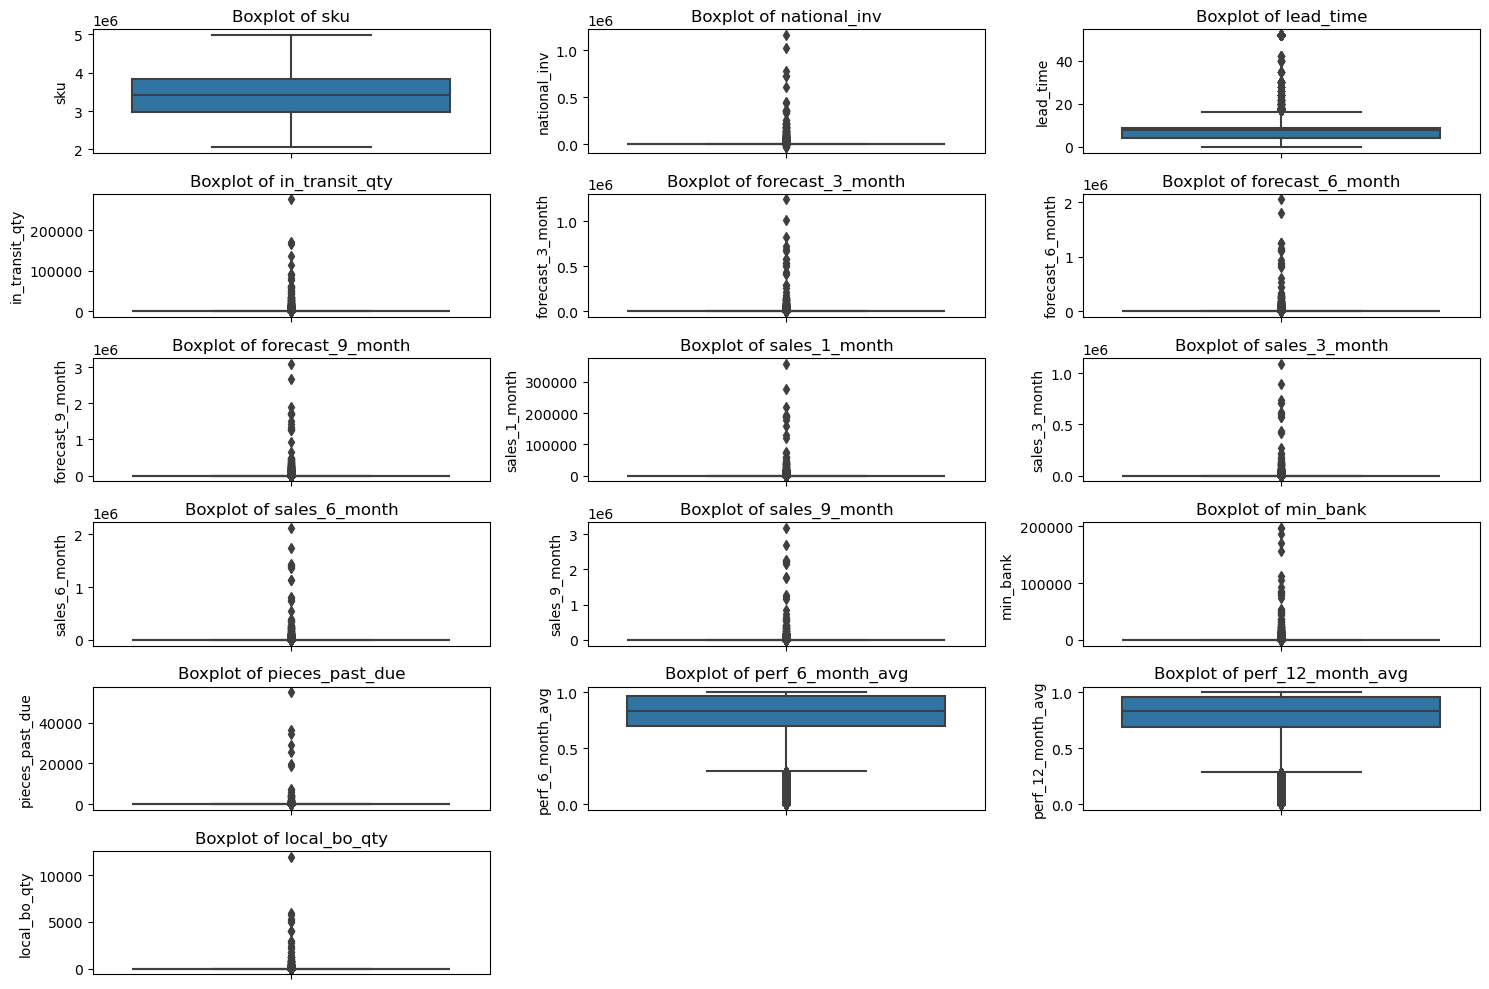

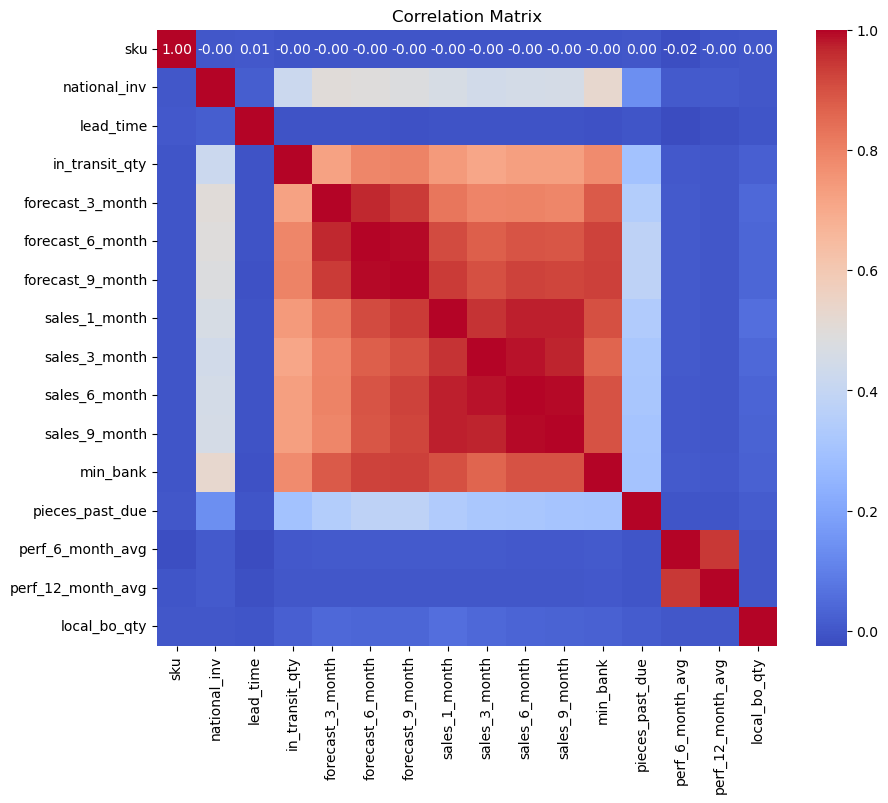

ValueError: A given column is not a column of the dataframe

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from lightgbm import LGBMClassifier
import numpy as np

# Load data
product_train_df = pd.read_csv('product_train.csv')

# Check if the 'went_on_backorder' column exists
if 'went_on_backorder' not in product_train_df.columns:
    raise KeyError("'went_on_backorder' column is missing from the dataset")

# Data Preprocessing
# Identifying numeric and categorical columns
numeric_features = product_train_df.select_dtypes(include=['int64', 'float64']).columns
categorical_features = product_train_df.select_dtypes(include=['object']).columns

# Fill missing values for numeric columns with their median
for col in numeric_features:
    product_train_df[col].fillna(product_train_df[col].median(), inplace=True)

# Fill missing values for categorical columns with their mode
for col in categorical_features:
    product_train_df[col].fillna(product_train_df[col].mode()[0], inplace=True)

# Exploratory Data Analysis
# Boxplots for numerical features to detect outliers
plt.figure(figsize=(15, 10))

# Dynamically calculate the number of rows and columns for subplots
n_features = len(numeric_features)
n_cols = 3
n_rows = int(np.ceil(n_features / n_cols))  # Ceiling division to handle cases where features don't perfectly divide

for i, col in enumerate(numeric_features, 1):
    plt.subplot(n_rows, n_cols, i)
    sns.boxplot(y=product_train_df[col])
    plt.title(f'Boxplot of {col}')

plt.tight_layout()
plt.show()

# Correlation matrix heatmap (excluding non-numeric columns)
# Filter numeric columns only before calculating correlation
numeric_df = product_train_df.select_dtypes(include=[np.number])

# Correlation matrix heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(numeric_df.corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

# Feature and target preparation
X = product_train_df.drop('went_on_backorder', axis=1)
y = product_train_df['went_on_backorder'].apply(lambda x: 1 if x == 'Yes' else 0)

# Preprocessing for numeric and categorical features
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combine transformers into a ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

# Integrating preprocessor with a modeling pipeline
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('classifier', LGBMClassifier(n_estimators=200, learning_rate=0.05, max_depth=5, random_state=42))])

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit the model
pipeline.fit(X_train, y_train)

# Predictions and evaluation
y_pred = pipeline.predict(X_test)
y_pred_proba = pipeline.predict_proba(X_test)[:, 1]  # Probability estimates

print("Classification Report:")
print(classification_report(y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("ROC AUC Score:")
print(roc_auc_score(y_test, y_pred_proba))

# Feature Importance Visualization (if applicable)
try:
    # Extracting feature importance from the classifier
    feature_importances = pd.DataFrame({
        'feature': numeric_features.tolist() + list(pipeline.named_steps['preprocessor'].transformers_[1][1].named_steps['onehot'].get_feature_names_out(categorical_features)),
        'importance': pipeline.named_steps['classifier'].feature_importances_
    })
    feature_importances.sort_values('importance', ascending=False, inplace=True)

    # Plotting feature importance
    plt.figure(figsize=(10, 6))
    sns.barplot(data=feature_importances, x='importance', y='feature')
    plt.title('Feature Importance')
    plt.show()
except AttributeError:
    print("Feature importance not available for the pipeline configuration.")
